<a href="https://colab.research.google.com/github/arkB/baby-steps-of-rl-ja/blob/master/note/RF_Day3_FL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---

Agent

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import gym
from gym.envs.registration import register

register(id="FrozenLakeEasy-v0", entry_point="gym.env.toy_text:FrozenLakeEnv",
         kwargs={"is_slippery": False})

def show_q_value(Q):
  env = gym.make("FrozenLake-v0")
  nrow = env.unwrapped.nrow
  ncol = env.unwrapped.ncol
  state_size = 3
  q_nrow = nrow * state_size
  q_ncol = ncol * state_size
  reward_map = np.zeros((q_nrow, q_ncol))
  
  for r in range(nrow):
    for c in range(ncol):
      s = r * nrow + c
      state_exist = False
      if isinstance(Q, dict) and s in Q:
        state_exist = True
      elif isinstance(Q, (np.ndarray, np.generic)) and s < Q.shape[0]:
        state_exist = Ture
      
      if state_exist:
        # At the display map, the vertical index reversed.
        _r = 1 + (nrow - 1 -r) * state_size
        _c = 1 + c * state_size
        reward_map[_r][_c - 1] = Q[s][0] # LEFT = 0
        reward_map[_r - 1][_c] = Q[s][1] # DOWN = 1
        reward_map[_r][_c + 1] = Q[s][2] # RIGHT = 2
        reward_map[_r][_c] = np.mean(Q[s]) # Center
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  plt.imshow(reward_map, cmap=cm.RdYlGn, interpolation="bilinear",
             vmax=abs(reward_map).max(), vmin=-abs(reward_map).max())
  ax.set_xlim(-0.5, q_ncol - 0.5)
  ax.set_ylim(-0.5, q_nrow - 0.5)
  ax.set_xticks(np.arange(-0.5, q_ncol, state_size))
  ax.set_yticks(np.arange(-0.5, q_nrow, state_size))
  ax.set_xticklabels(range(ncol + 1))
  ax.set_yticklabels(range(nrow + 1))
  ax.grid(which="both")
  plt.show



---

Monte Carlo

In [0]:
# show upload dialog
from google.colab import files
uploaded = files.upload()

Saving el_agent.py to el_agent.py
Saving frozen_lake_util.py to frozen_lake_util.py


In [0]:
import math
from collections import defaultdict
import gym
from el_agent import ELAgent
from frozen_lake_util import show_q_value

class MonteCarloAgent(ELAgent):
  def __init__(self, epsilon=0.1):
    super().__init__(epsilon)
  
  def learn(self, env, episode_count=1000, gamma=0.9,
            render=False, report_interval=50):
    self.init_log()
    self.Q = defaultdict(lambda: [0] * len(actions))
    N = defaultdict(lambda: [0] * len(actions))
    actions = list(range(env.action_space.n))
    
    for e in range(episode_count):
      s = env.reset()
      done = False
      # 1. Play until the end of episode.
      experience = []
      while not done:
        if render:
           env.render()
        a = self.policy(s, actions)
        n_state, reward, done, info = env.step(a)
        experience.append({"state":s, "action":a, "reward": reward})
        s = n_state
      else:
        self.log(reward)
        
      # 2. Evaluate each state, action.
      for i, x in enumerate(experience):
        s, a = x["state"], x["action"]
        
        # Calculate discounted future reward of s.
        G, t = 0, 0
        for j in range(i, len(experience)):
          G += math.pow(gamma, t) * experience[j]["reward"]
          t += 1
          
        N[s][a] += 1 # count of s, a pair
        alpha = 1 / N[s][a]
        self.Q[s][a] += alpha * (G - self.Q[s][a])
        
      if e != 0 and e % report_interval == 0:
        self.show_reward_log(episode=e)

At Episode 50 average reward is 0.0 (+/-0.0).
At Episode 100 average reward is 0.62 (+/-0.485).
At Episode 150 average reward is 0.92 (+/-0.271).
At Episode 200 average reward is 0.92 (+/-0.271).
At Episode 250 average reward is 0.8 (+/-0.4).
At Episode 300 average reward is 0.84 (+/-0.367).
At Episode 350 average reward is 0.9 (+/-0.3).
At Episode 400 average reward is 0.9 (+/-0.3).
At Episode 450 average reward is 0.9 (+/-0.3).


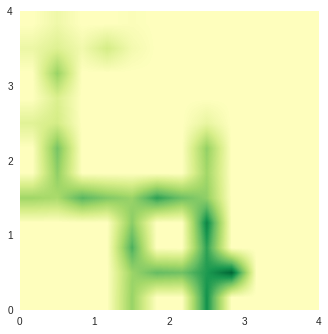

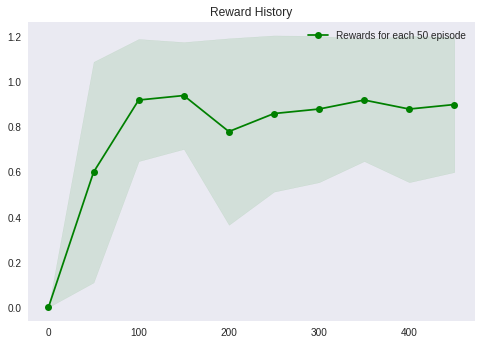

In [0]:
def train():
  agent = MonteCarloAgent(epsilon=0.1)
  env = gym.make("FrozenLakeEasy-v0")
  agent.learn(env, episode_count=500)
  show_q_value(agent.Q)
  agent.show_reward_log()
  
if __name__ == "__main__":
  train()



---

Q-learning

In [0]:
# show upload dialog
from google.colab import files
uploaded = files.upload()

In [0]:
from collections import defaultdict
import gym
from el_agent import ELAgent
from frozen_lake_util import show_q_value

class QLearningAgent(ELAgent):
  def __init__(self, epsilon=0.1):
    super().__init__(epsilon)
    
  def learn(self, env, episode_count=1000, gamma=0.9,
            learning_rate=0.1, render=False, report_interval=50):
    self.init_log()
    self.Q = defaultdict(lambda: [0] * len(actions))
    actions = list(range(env.action_space.n))
    for e in range(episode_count):
      s = env.reset()
      done = False
      while not done:
        if render:
          env.render()
        a = self.policy(s, actions)
        n_state, reward, done, info = env.step(a)
        
        gain = reward + gamma * max(self.Q[n_state])
        estimated = self.Q[s][a]
        self.Q[s][a] += learning_rate * (gain - estimated)
        s = n_state
        
      else:
        self.log(reward)
        
      if e != 0 and e % report_interval == 0:
        self.show_reward_log(episode=e)

At Episode 50 average reward is 0.02 (+/-0.14).
At Episode 100 average reward is 0.08 (+/-0.271).
At Episode 150 average reward is 0.72 (+/-0.449).
At Episode 200 average reward is 0.94 (+/-0.237).
At Episode 250 average reward is 0.96 (+/-0.196).
At Episode 300 average reward is 0.88 (+/-0.325).
At Episode 350 average reward is 0.94 (+/-0.237).
At Episode 400 average reward is 0.84 (+/-0.367).
At Episode 450 average reward is 0.82 (+/-0.384).


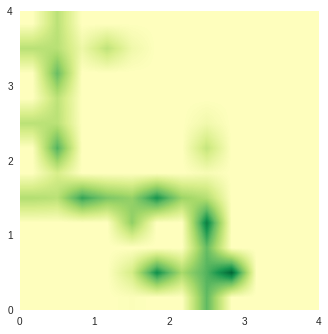

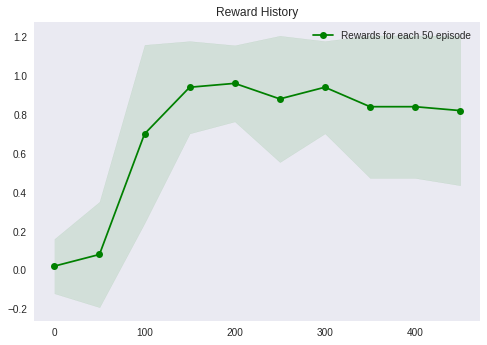

In [0]:
def train():
  agent = QLearningAgent()
  env = gym.make("FrozenLakeEasy-v0")
  agent.learn(env, episode_count=500)
  show_q_value(agent.Q)
  agent.show_reward_log()
  
if __name__ == "__main__":
  train()



---

SARSA

In [0]:
# show upload dialog
from google.colab import files
uploaded = files.upload()

Saving el_agent.py to el_agent (1).py
Saving frozen_lake_util.py to frozen_lake_util (1).py


In [0]:
from collections import defaultdict
import gym
from el_agent import ELAgent
from frozen_lake_util import show_q_value

class SARSAAgent(ELAgent):
  
  def __init__(self, epsilon=0.1):
    super().__init__(epsilon)
    
  def learn(self, env, episode_count=1000, gamma=0.9,
            learning_rate=0.1, render=False, report_interval=50):
    self.init_log()
    self.Q = defaultdict(lambda: [0] * len(actions))
    actions = list(range(env.action_space.n))
    for e in range(episode_count):
      s = env.reset()
      done = False 
      a = self.policy(s, actions)
      while not done:
        if render:
          env.render()
        n_state, reward, done, info = env.step(a)
        
        n_action = self.policy(n_state, actions)
        gain = reward + gamma * self.Q[n_state][n_action]
        estimated = self.Q[s][a]
        self.Q[s][a] += learning_rate * (gain - estimated)
        s = n_state
        a = n_action
      else:
        self.log(reward)
        
      if e != 0 and e % report_interval == 0:
        self.show_reward_log(episode=e)

At Episode 50 average reward is 0.02 (+/-0.14).
At Episode 100 average reward is 0.02 (+/-0.14).
At Episode 150 average reward is 0.4 (+/-0.49).
At Episode 200 average reward is 0.92 (+/-0.271).
At Episode 250 average reward is 0.86 (+/-0.347).
At Episode 300 average reward is 0.94 (+/-0.237).
At Episode 350 average reward is 0.82 (+/-0.384).
At Episode 400 average reward is 0.94 (+/-0.237).
At Episode 450 average reward is 0.86 (+/-0.347).


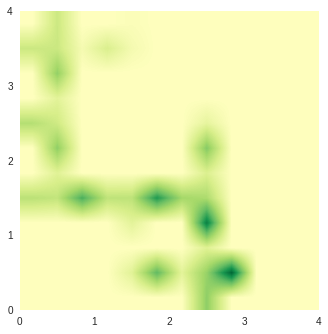

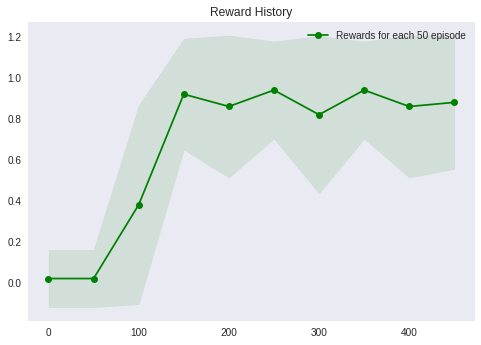

In [0]:
def train():
  agent = SARSAAgent()
  env = gym.make("FrozenLakeEasy-v0")
  agent.learn(env, episode_count=500)
  show_q_value(agent.Q)
  agent.show_reward_log()
  
if __name__ == "__main__":
  train()



---

Actor Critic

In [2]:
# show upload dialog
from google.colab import files
uploaded = files.upload()

Saving el_agent.py to el_agent.py
Saving frozen_lake_util.py to frozen_lake_util.py


In [0]:
import numpy as np
import gym
from el_agent import ELAgent
from frozen_lake_util import show_q_value

class Actor(ELAgent):
  
  def __init__(self, env):
    super().__init__(epsilon=1)
    nrow = env.observation_space.n
    ncol = env.action_space.n
    self.actions = list(range(env.action_space.n))
    self.Q = np.random.uniform(0, 1, nrow * ncol).reshape((nrow, ncol))
    
  def softmax(self, x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)
  
  def policy(self, s):
    a = np.random.choice(self.actions, 1,
                         p=self.softmax(self.Q[s]))
    return a[0]
  
class Critic():
  def __init__(self, env):
    states = env.observation_space.n
    self.V = np.zeros(states)
    
class ActorCritic():
  
  def __init__(self, actor_class, critic_class):
    self.actor_class = actor_class
    self.critic_class = critic_class
    
  def train(self, env, episode_count=1000, gamma=0.9,
            learning_rate=0.1, render=False, report_interval=50):
    actor = self.actor_class(env)
    critic = self.critic_class(env)
    
    actor.init_log()
    for e in range(episode_count):
      s = env.reset()
      done = False
      while not done:
        if render:
          env.render()
        a = actor.policy(s)
        n_state, reward, done, info = env.step(a)
        
        gain = reward + gamma * critic.V[n_state]
        estimated = critic.V[s]
        td = gain - estimated
        actor.Q[s][a] += learning_rate * td
        critic.V[s] += learning_rate * td
        s = n_state
        
      else:
        actor.log(reward)
        
      if e != 0 and e % report_interval == 0:
        actor.show_reward_log(episode=e)
        
    return actor, critic

At Episode 50 average reward is 0.0 (+/-0.0).
At Episode 100 average reward is 0.04 (+/-0.196).
At Episode 150 average reward is 0.0 (+/-0.0).
At Episode 200 average reward is 0.02 (+/-0.14).
At Episode 250 average reward is 0.02 (+/-0.14).
At Episode 300 average reward is 0.0 (+/-0.0).
At Episode 350 average reward is 0.02 (+/-0.14).
At Episode 400 average reward is 0.0 (+/-0.0).
At Episode 450 average reward is 0.0 (+/-0.0).
At Episode 500 average reward is 0.0 (+/-0.0).
At Episode 550 average reward is 0.0 (+/-0.0).
At Episode 600 average reward is 0.02 (+/-0.14).
At Episode 650 average reward is 0.0 (+/-0.0).
At Episode 700 average reward is 0.0 (+/-0.0).
At Episode 750 average reward is 0.04 (+/-0.196).
At Episode 800 average reward is 0.0 (+/-0.0).
At Episode 850 average reward is 0.0 (+/-0.0).
At Episode 900 average reward is 0.0 (+/-0.0).
At Episode 950 average reward is 0.02 (+/-0.14).
At Episode 1000 average reward is 0.0 (+/-0.0).
At Episode 1050 average reward is 0.0 (+/-0.

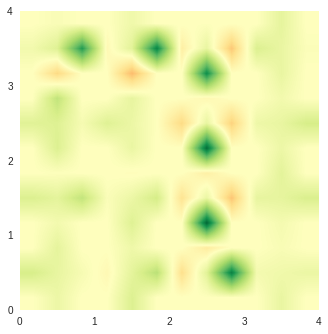

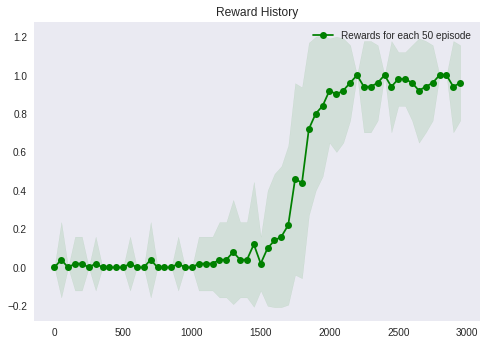

In [6]:
def train():
  trainer = ActorCritic(Actor, Critic)
  env = gym.make("FrozenLakeEasy-v0")
  actor, critic = trainer.train(env, episode_count=3000)
  show_q_value(actor.Q)
  actor.show_reward_log()
  
if __name__ == "__main__":
  train()



---

Monte Carlo

In [0]:
import numpy as np
import matplotlib.pyplot as plt

class ELAgent():
  
  def __init__(self, epsilon):
    self.Q = {}
    self.epsilon = epsilon
    self.reward_log = []
    
  def policy(self, s, actions):
    if np.random.random() < self.epsilon:
      return np.random.randint(len(actions))
    else:
      if s in self.Q and sum(self.Q[s]) != 0:
        return np.argmax(self.Q[s])
      else:
        return np.random.randint(len(actions))
      
  def init_log(self):
    self.reward_log = []
    
  def log(self, reward):
    self.reward_log.append(reward)
    
  def show_reward_log(self, interval=50, episode=-1):
    if episode > 0:
      rewards = self.reward_log[-interval:]
      mean = np.round(np.mean(rewards), 3)
      std = np.round(np.std(rewards), 3)
      print("At Episode {} average reward is {} (+/-{}).".format(
            episode, mean, std))
    else:
      indices = list(range(0, len(self.reward_log), interval))
      means = []
      stds = []
      for i in indices:
        rewards = self.reward_log[i:(i + interval)]
        means.append(np.mean(rewards))
        stds.append(np.std)
      means = np.array(means)
      stds = np.array(stds)
      plt.figure()
      plt.title("Reward History")
      plt.grid()
      plt.fill_between(indices, means - stds, means + stds,
                       alpha=0.1, color="g")
      plt.plot(indices, means, "o-", color="g", 
               label="Rewards for each {} episode".format(interval))
      plt.legend(loc="best")
      plt.show()

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import gym
from gym.envs.registration import register

register(id="FrozenLakeEasy-v0", entry_point="gym.env.toy_text:FrozenLakeEnv",
         kwargs={"is_slippery": False})

def show_q_value(Q):
  env = gym.make("FrozenLake-v0")
  nrow = env.unwrapped.nrow
  ncol = env.unwrapped.ncol
  state_size = 3
  q_nrow = nrow * state_size
  q_ncol = ncol * state_size
  reward_map = np.zeros((q_nrow, q_ncol))
  
  for r in range(nrow):
    for c in range(ncol):
      s = r * nrow + c
      state_exist = False
      if isinstance(Q, dict) and s in Q:
        state_exist = True
      elif isinstance(Q, (np.ndarray, np.generic)) and s < Q.shape[0]:
        state_exist = True
      
      if state_exist:
        # At the display map, the vertical index reversed.
        _r = 1 + (nrow - 1 -r) * state_size
        _c = 1 + c * state_size
        reward_map[_r][_c - 1] = Q[s][0] # LEFT = 0
        reward_map[_r - 1][_c] = Q[s][1] # DOWN = 1
        reward_map[_r][_c + 1] = Q[s][2] # RIGHT = 2
        reward_map[_r][_c] = np.mean(Q[s]) # Center
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  plt.imshow(reward_map, cmap=cm.RdYlGn, interpolation="bilinear",
             vmax=abs(reward_map).max(), vmin=-abs(reward_map).max())
  ax.set_xlim(-0.5, q_ncol - 0.5)
  ax.set_ylim(-0.5, q_nrow - 0.5)
  ax.set_xticks(np.arange(-0.5, q_ncol, state_size))
  ax.set_yticks(np.arange(-0.5, q_nrow, state_size))
  ax.set_xticklabels(range(ncol + 1))
  ax.set_yticklabels(range(nrow + 1))
  ax.grid(which="both")
  plt.show

In [0]:
import math
from collections import defaultdict
import gym

class MonteCarloAgent(ELAgent):
  
  def __init__(self, epsilon=0.1):
    super().__init__(epsilon)
    
  def learn(self, env, episode_count=1000, gamma=0.9,
            render=False, report_interval=50):
    self.init_log()
    self.Q = defaultdict(lambda: [0] * len(actions))
    N = defaultdict(lambda: [0] * len(actions))
    actions = list(range(env.actions_space.n))
    
    for e in range(episode_count):
      s = env.reset()
      done = False
      # 1. Play util the end of episode.
      experience = []
      while not done:
        if render:
          env.render()
        a = self.policy(s, actions)
        n_state, reward, done, info = env.step(a)
        experience.append({"state": s, "action": a, "reward": reward})
        s = n_state
      else:
        self.log(reward)
      # 2. Evaluate each state, action.
      for i, x in enumerate(experience):
        s, a = x["state"], x["action"]
        
        # Calculate discounted future reward of s.
        G, t = 0, 0
        for j in range(i, len(experience)):
          G += math.pow(gamma, t) * experience[j]["reward"]
          t += 1
          
        N[s][a] += 1
        alpha = 1 / N[s][a]
        self.Q[s][a] += alpha * (G - self.Q[s][a])
        
      if e != 0 and e % report_interval == 0:
        self.show_reward_log(episode=e)

In [0]:
def train():
  agent = MonteCarloAgent(epsilon=0.1)
  env = gym.make("FrozenLakeEasy-v0")
  #agent.learn(env, episode_count=500)
  #show_q_value(agent.Q)
  #agent.show_reward_log()
  
if __name__ == "__main__":
  train()